# Future predictions

In this notebook we train and calibrate our best-performing model using all available data to predict whether or not a given player will play in the NBA _at any point_ during the 2024-2025 season.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px

from HelperFunctions import *

## Loading the full dataset

In [2]:
#load/scale data
df        = pd.read_csv("full_data.csv")
df_scaled = ImputeAndScale(df.copy())
features  = df_scaled.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])

In [3]:
#make 2023-2024 season the test set
df_train = df_scaled.loc[df_scaled.SEASON_START < 2017]
df_test  = df_scaled.loc[df_scaled.SEASON_START >= 2017]

In [4]:
#split training data into a train set and a calibration set
df_tt, df_cal = train_test_split(df_train, test_size=0.2, shuffle=True, 
                                 random_state=815, stratify=df_train.IN_LEAGUE_NEXT)

## Training the model

In [5]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

model = Pipeline([('smote', SMOTE(random_state=23)),
                  ('xgb', XGBClassifier(n_estimators=350, learning_rate=0.005, random_state=206))])

model.fit(df_tt[features], df_tt.IN_LEAGUE_NEXT)

model_cal = CalibratedClassifierCV(model, cv="prefit")
model_cal.fit(df_cal[features], df_cal.IN_LEAGUE_NEXT)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('smote',
                                                  SMOTE(random_state=23)),
                                                 ('xgb',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=None,
                                                                colsample_bytree=None,
                                                                device=None,
                                                                early_stopping_rounds=None,
                                                                enable_categorical=False,
                                                                eval_metric=None,
                                                                feature_types=None,
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.005,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=350,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=206, ...))]))

## Visualize training data

Make scatterplots with a choice of predictors on the x and y axes, and color the points based on `IN_LEAGUE_NEXT`.

In [6]:
def visualize_train(x, y, year):
    sns.scatterplot(data=df.loc[df.SEASON_START==year], x=x, y=y, hue="IN_LEAGUE_NEXT", palette=["lightcoral", "black"], marker='.')
    plt.show()
    return None

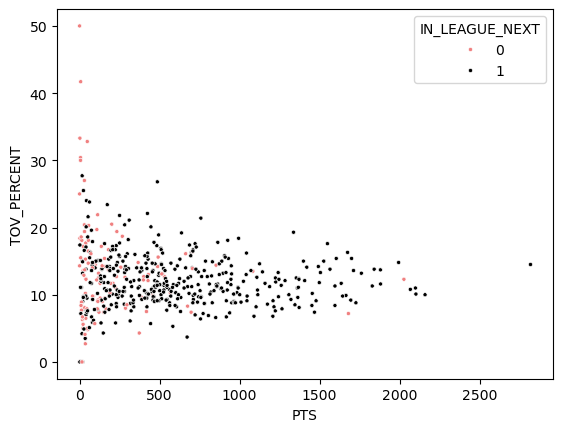

In [7]:
visualize_train("PTS", "TOV_PERCENT", 2018)

In [17]:
def plotly_train(x, y, year):
    df["Retained"] = "No"
    df.loc[df.IN_LEAGUE_NEXT == 1, "Retained"] = "Yes"
    
    fig = px.scatter(df.loc[df.SEASON_START==year], x=x, y=y, color="Retained",
                    hover_name="NAME", hover_data=["TEAMS_LIST"])
    fig.show()
    return None

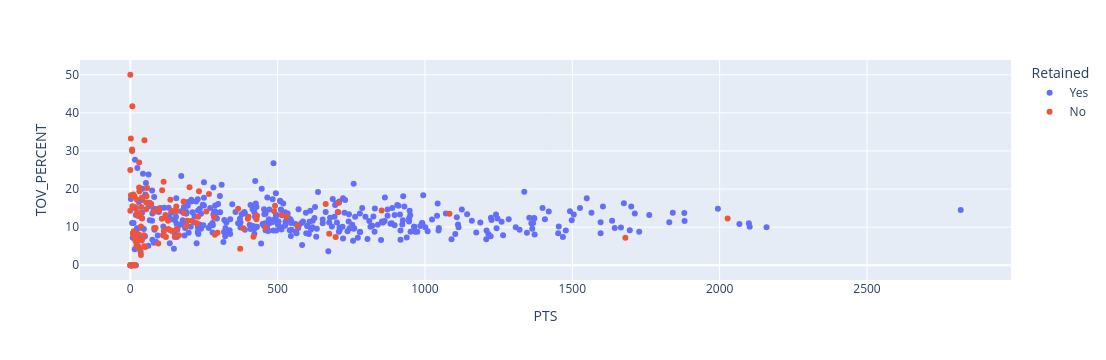

In [18]:
plotly_train("PTS", "TOV_PERCENT", 2018)

## Visualize model output

Plots arbitrary predictors on x axis vs predicted probability on y axis for unseen test data (2016-2022).

In [110]:
#convert teams list from strings to actual lists
df_scaled["TEAMS_AS_LIST"] = df_scaled.apply(lambda x: eval(x.TEAMS_LIST), axis=1)
#explode out teams
df_scaled_exploded = df_scaled.explode("TEAMS_AS_LIST", ignore_index=True)

In [111]:
def plot_bar_team_season(team, season):
    df_temp = df_scaled_exploded.loc[(df_scaled_exploded.TEAMS_AS_LIST == team) & (df_scaled_exploded.SEASON_START == season)].copy()

    df_temp["PROB"] = model_cal.predict_proba(df_temp[features])[:, 1]

    sns.barplot(data=df_temp.sort_values("PROB"), x="NAME", y="PROB")
    plt.xticks(rotation='vertical')

    plt.show()

    return None

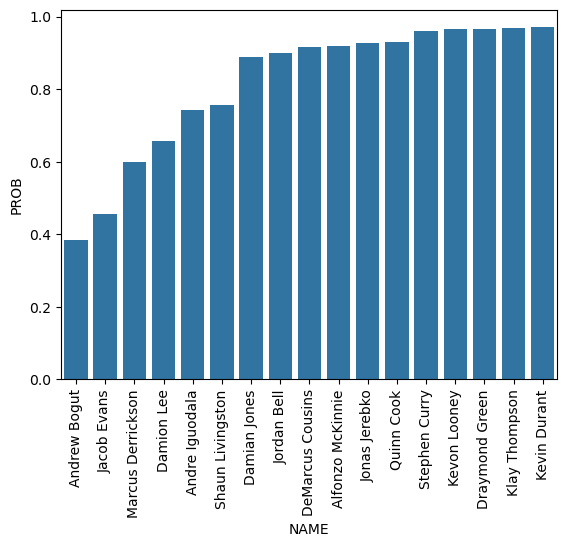

In [112]:
plot_bar_team_season("GSW", 2018)

In [113]:
def plotly_bar(team, season):
    df_temp = df_scaled_exploded.loc[(df_scaled_exploded.TEAMS_AS_LIST == team) & (df_scaled_exploded.SEASON_START == season)].copy()

    df_temp["PROB"] = model_cal.predict_proba(df_temp[features])[:, 1]
    df_temp["PREDICT"] = model.predict(df_temp[features])

    df_temp["Retained"] = "No"
    df_temp.loc[df_temp.IN_LEAGUE_NEXT == 1, "Retained"] = "Yes"

    df_temp["Predicted class"] = "No"
    df_temp.loc[df_temp.PREDICT == 1, "Predicted class"] = "Yes"

    if(season != 2023):
        fig = px.bar(df_temp, x="NAME", y="PROB", color="Retained",
                    color_discrete_map={"Yes":'cornflowerblue', "No":'lightcoral'})
    else:
        fig = px.bar(df_temp, x="NAME", y="PROB", color="Predicted class",
                    color_discrete_map={"Yes":'cornflowerblue', "No":'lightcoral'})

    fig.show()

    return None

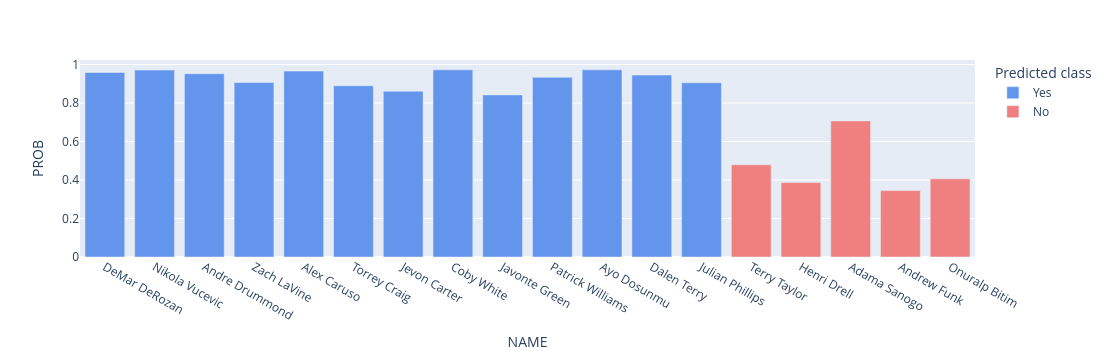

In [114]:
plotly_bar("CHI", 2023)